In [14]:
import os
from obspy import read
from obspy.core import UTCDateTime

In [9]:
data_dir = '/home/b/.seisml/data/triggered_tremor/'
pos_dir = os.path.join(data_dir, 'positive/Japan_20120411/positive')
neg_dir = os.path.join(data_dir, 'negative')
positive_files = os.listdir(pos_dir)
negative_file = os.listdir(neg_dir)

FileNotFoundError: [Errno 2] No such file or directory: '/home/b/.seisml/data/triggered_tremor/positive/Japan_20120411/positive'

In [15]:
def trim_positive(trace, rate=100, seconds=1000, speed=4.0):
    
    try:
        dist = trace.stats.sac.dist
    except:
        print('no dist')
        return None
    
    sampling_rate = trace.stats.sampling_rate
    starttime = trace.stats.starttime
    endtime = trace.stats.endtime
    
    if endtime - starttime < seconds:
        return None

    new_start_time = starttime + (dist/speed)

    if endtime > (new_start_time + seconds):
        new_end_time = new_start_time + seconds
    else:
        new_start_time = endtime - seconds
        new_end_time = endtime

    trimmed = trace.trim(new_start_time, new_end_time)
    
    
    return trimmed.detrend('demean').resample(rate)[:rate*seconds]



In [16]:
def trim_negative(trace, rate=100, seconds=1000, start_sec=400):
    starttime = trace.stats.starttime
    endtime = trace.stats.endtime
    
    if endtime - starttime < seconds:
        return None
    elif endtime - starttime > start_sec + seconds:
        trimmed = trace.trim(starttime + start_sec, starttime + (start_sec + seconds))
    else:
        trimmed = trace.trim(endtime - seconds, endtime)
    
    return trimmed.detrend('demean').resample(rate)[:rate*seconds]
        

Hi-net.N.BEWH..N | 2012-04-11T08:33:38.000000Z - 2012-04-11T09:40:17.990000Z | 100.0 Hz, 400000 samples


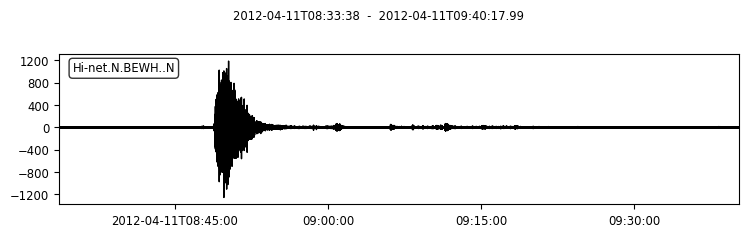

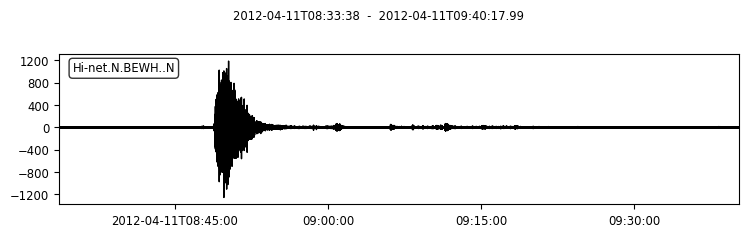

In [8]:
pos_stream = read(os.path.join(pos_dir, positive_files[0]))
print(pos_stream[0])
pos_stream.plot()

In [11]:
new_pos = trim_positive(pos_stream[0])
print(new_pos)

[ 2.12204905  5.14189961  7.44310952 ..., -0.34119814 -1.16326324
 -1.64981549]


AttributeError: 'numpy.ndarray' object has no attribute 'plot'

IU.PAB.00.BHZ | 2011-03-04T06:00:00.019538Z - 2011-03-04T06:29:59.969538Z | 20.0 Hz, 36000 samples


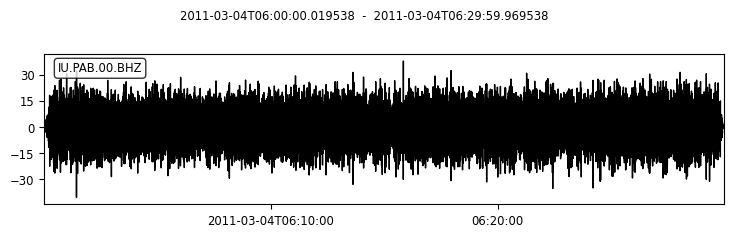

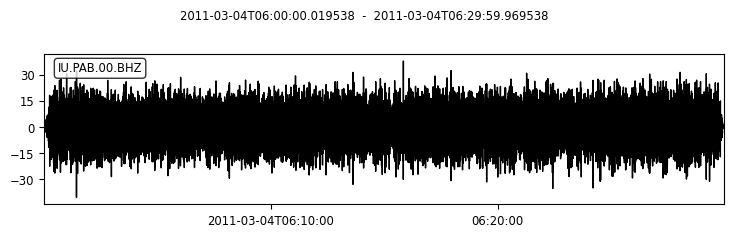

In [10]:
neg_stream = read(os.path.join(neg_dir, negative_file[0]))
print(neg_stream[0])
neg_stream[0].plot()

IU.PAB.00.BHZ | 2011-03-04T06:06:40.059538Z - 2011-03-04T06:23:20.059538Z | 100.0 Hz, 100001 samples


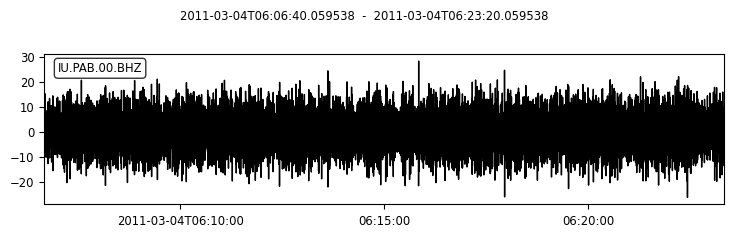

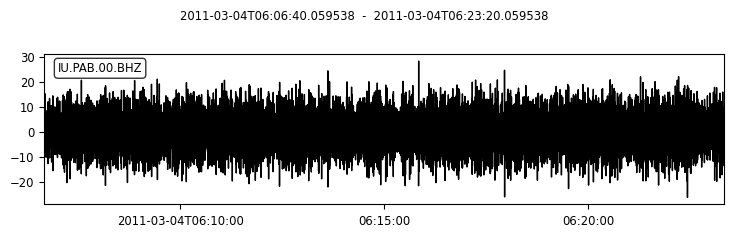

In [13]:
print(trim(neg_stream[0]).resample(100))
trim(neg_stream[0]).resample(100).plot()

## Preprocess and save data

In [17]:
import pickle, h5py

data_dir = '/home/b/.seisml/data/triggered_tremor_raw/'
new_data_dir = '/home/b/.seisml/data/triggered_tremor_processed/'
pos_dir = os.path.join(data_dir, 'positive/')
neg_dir = os.path.join(data_dir, 'negative')

if not os.path.exists(new_data_dir):
    os.mkdir(new_data_dir)

samples = []
labels = []

## negative

In [18]:
negative_files = os.listdir(neg_dir)

for f in negative_files:
    tr = read(os.path.join(neg_dir, f))[0]
    data = trim_negative(tr)
    if data is not None:
        pickle.dump(
            data, 
            open(os.path.join(new_data_dir, 'negative_{}.p'.format(f)), 'wb')
        )
        samples.append(data)
        labels.append(0)

In [19]:
positive_dirs = os.listdir(pos_dir)

for dir in positive_dirs:
    for f in list(filter(lambda x: x.split('.')[-1].lower() == 'sac' and x[0] != '.', os.listdir(os.path.join(pos_dir, dir, 'positive')))):
        tr = read(os.path.join(pos_dir, dir, 'positive', f))[0]
        data = trim_positive(tr)
        if data is not None:
            pickle.dump(
                data, 
                open(os.path.join(new_data_dir, 'positive_{}.p'.format(f)), 'wb')
            )
            samples.append(data)
            labels.append(1)

no dist
no dist
no dist
no dist
no dist
no dist


In [21]:
import numpy as np

samples = np.vstack(samples)
labels = np.vstack(labels)

randomize = np.arange(len(labels))
np.random.shuffle(randomize)

In [22]:
hf = h5py.File('triggered_tremor_sample.h5', 'w')

hf.create_dataset('X', data=samples[randomize])
hf.create_dataset('y', data=labels[randomize])

hf.close()

In [23]:
import json

metadata = {
    'size': len(labels),
    'positive': int(np.sum(labels)),
    'negative': len(labels) - int(np.sum(labels)),
    'sample_rate': '100Hz',
    'sample_size': int(samples.shape[-1]) 
}

print(metadata)

with open('metadata.json', 'w') as f:
    json.dump(metadata, f)

{'size': 717, 'positive': 327, 'negative': 390, 'sample_rate': '100Hz', 'sample_size': 100000}


In [93]:
import json

metadata = {
    'size': len(labels),
    'positive': int(np.sum(labels)),
    'negative': len(labels) - int(np.sum(labels)),
    'sample_rate': '100Hz',
    'sample_size': int(samples.shape[-1]) 
}

print(metadata)

with open('metadata.json', 'w') as f:
    json.dump(metadata, f)

{'size': 717, 'positive': 327, 'negative': 390, 'sample_rate': '100Hz', 'sample_size': 100000}
